# Moving Horizon Estimator

Simple implementation - see 12-10 for relevant equations

In [36]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy import linalg as la
from scipy.integrate import odeint
from scipy.optimize import minimize

from casadi import *
from pylab import plot, step, figure, legend, show, spy

opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
#opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3}

Running Python: 3.8.16


In [37]:
#Simulate the system
N = 100 # npts
Nx = 3 # state dim
Ny = 2 # number of outputs
Nwind = 15 # Pick an estimation window size
KK = np.arange(N+1+Nwind) # time steps 

Vv = 0.25  # Velocity
dt = 2 # step time
np.random.seed(10) # set for consistent results
d2r = np.pi/180

# Process noise 
Wd = np.array([[0.1**2, 0, 0],[0, 0.1**2, 0],[0, 0, (1*d2r)**2]])
# sensor noise
Rd = np.array([[0.5**2, 0],[0, (2*d2r)**2]]) # meas noises

# location of the tracking sensor
X_pos = np.array([-6, 0])

# storage 
Xsm = np.zeros((Nx,1,N+1+Nwind))

# IC 
x0 = np.array([0, 0, 90*np.pi/180]) # actual initial condition
Q0 = np.array([[2**2, 0, 0],[0, 2**2, 0],[0, 0, (5*d2r)**2]])

In [38]:
class Make_Model:
    def __init__ (self):
        self.N = N        # number of points         
        self.Nwind = Nwind        # number of points         
        self.opti = None    # initial with none
        self.vars = None  # initial with none
        self.sol = None     # initial with none
        self.Tf = self.Nwind*dt      # None if free end time problem, else give number
        self.Y = None
        self.u = None
        self.kstart = 0
        self.X0 = copy.deepcopy(x0)
        self.Xm = copy.deepcopy(x0)
        self.Q0 = copy.deepcopy(Q0)
        self.Qm = copy.deepcopy(Q0)
        self.W = copy.deepcopy(x0)
        self.Wd = Wd
        self.Rd = Rd

    def deriv(self,x,u,t):  # dynamics
        return vertcat(Vv * np.cos(x[2]), Vv * np.sin(x[2]), u + Beta*u**3)

    def meas(self,x,t):
        e = x[0:2] - MX(X_pos)
        return vertcat(sqrt(dot(e,e)),x[2])

In [39]:
# data Y exists
# inputs U known
# find the W (add to the state) and V (meas error) 
def create_opti(Model):
    opti = Opti() # Optimization problem
    # ---- decision variables ---------
    cX = opti.variable(Nx,Model.Nwind+1) # state trajectory
    cW = opti.variable(Nx,Model.Nwind)   # control trajectory (throttle)
    
    dt = Model.Tf / Model.Nwind # length of a control interval
    
    # ---- dynamic constraints --------
    f = lambda x,u,t: Model.deriv(x,u,t) # dx/dt = f(x,u,t)
    # ---- measurements --------
    h = lambda x,t: Model.meas(x,t) # y = h(x,t)

    for k in range(Model.Nwind): # loop over control intervals
        uinp = Model.u[:,Model.kstart+k]
        k1 = f(cX[:,k],         uinp,k*dt)
        k2 = f(cX[:,k]+dt/2*k1, uinp,(k+1/2)*dt)
        k3 = f(cX[:,k]+dt/2*k2, uinp,(k+1/2)*dt)
        k4 = f(cX[:,k]+dt*k3,   uinp,(k+1)*dt)
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) + cW[:,k] 
        opti.subject_to(cX[:,k+1]== x_next ) # close the gaps

    x0_err = cX[:,0] - MX(Model.Xm.reshape(Nx,1))
    J = dot(x0_err,mtimes(np.linalg.inv(np.atleast_2d(Model.Qm)),x0_err))

    for k in range(Model.Nwind): # loop over control intervals
        V = MX(MHE.Y[:,:,Model.kstart+k].reshape(Ny,1)) - h(cX[:,k],k*dt)         # meas error
        J += dot(V,mtimes(np.linalg.inv(np.atleast_2d(Model.Rd)),V))
        J += dot(cW[:,k],mtimes(np.linalg.inv(np.atleast_2d(Model.Wd)),cW[:,k]))
        
    # ---- objective          ---------
    opti.minimize(J)
    opti.solver('ipopt',opts0) # set numerical backend

    Model.vars = [cX, cW]
    Model.opti = opti
    
    return Model

def min_casadi(Model):
    # need to change u each time so do this for now
    Model = create_opti(Model) 
    cX,cW = Model.vars

    Model.opti.set_initial(cX[:,0],Model.Xm)
    if Model.sol is None:
        for k in range(Model.Nwind): # loop over control intervals
            Model.opti.set_initial(cW[:,k],sqrtm(Model.Wd)@np.vstack(randn(Nx)))
    else:
        for k in range(Model.Nwind-1): # loop over control intervals
            Model.opti.set_initial(cW[:,k],Model.W[:,k+1].reshape(Nx,1))
        Model.opti.set_initial(cW[:,Model.Nwind-1],sqrtm(Model.Wd)@np.vstack(randn(Nx)))

    # ---- initial values for solver ---
    Model.sol = Model.opti.solve()   # actual solve
    return Model 

In [40]:
MHE = Make_Model()

# choose some inputs so that something interesting happens
if 1:
    Beta = 0 # linear
else:
    Beta = -20 # nonlinear

# design some inputs so something happens    
uu = 6
MHE.u = np.zeros((1,MHE.N+1+Nwind))
MHE.u[0,0:int(MHE.N/4)] = uu*d2r
MHE.u[0,int(MHE.N/4):int(MHE.N/2)] = -uu*d2r
MHE.u[0,int(MHE.N/2):int(3*MHE.N/4)] = uu*d2r
MHE.u[0,int(3*MHE.N/4):N+1+Nwind] = -uu*d2r

In [41]:
# Define the dynamics and measurement functions
def fdyn(X,u,dt): 
    Xp1 = np.copy(X).reshape(Nx,1)
    Xp1[0] += dt * Vv * np.cos(Xp1[2]) 
    Xp1[1] += dt * Vv * np.sin(Xp1[2]) 
    Xp1[2] += dt * (u + Beta*u**3)  
    return Xp1

def hmeas(X):
    Y = np.zeros((Ny,1)).reshape(Ny,1)
    Y[0] = np.linalg.norm(X[0:2].reshape(Nx-1,1)-X_pos.reshape(Nx-1,1)) 
    Y[1] = copy.deepcopy(X[2])  
    return Y

def Hmeas(X):
    r = np.linalg.norm(X[0:2].reshape(Nx-1,1)-X_pos.reshape(Nx-1,1))
    return np.array([[(X[0]-X_pos[0])/r, (X[1]-X_pos[1])/r, 0],[0,0,1]]) 

def Lin_Ad(X):
    return np.array([[1,0, -dt*Vv*np.sin(X[2])],[0,1,dt*Vv*np.cos(X[2])],[0,0,1]])

def Prop_one_step(Xsol,Wsol,Q_kkm1,tkk):
    x_kk = copy.deepcopy(Xsol).reshape(Nx,1).flatten()
    # Compute predicted covariances using the linearized A and H
    Ad = Lin_Ad(x_kk)
    H = Hmeas(x_kk)
    # Qp at k
    Q_kk = np.linalg.inv(np.linalg.inv(Q_kkm1) + H.T@np.linalg.inv(np.atleast_2d(MHE.Rd))@H)
    # prop to next k
    Q_kp1k = Ad@Q_kk@Ad.T + MHE.Wd # Qm at next time step

    # Use updates to predict state at next time step 
    x_kp1k = fdyn(x_kk,MHE.u[:,tkk],dt).flatten() + Wsol.reshape(Nx,1).flatten()
    return x_kp1k, Q_kp1k, Q_kk

In [42]:
# plotting
def plot_sols(Xopt,KK,kstart,title='Simulation'):
    plt.figure(figsize=(12,8))
    plt.subplot(311)
    plt.plot(KK[kstart:kstart+Nwind],Xopt[0,0,0:Nwind],label=r'Optimized')
    plt.plot(KK[kstart:kstart+Nwind],Xsm[0,0,kstart:kstart+Nwind],label='Actual')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('X')
    plt.xlim([KK[kstart],KK[kstart+Nwind]])
    plt.grid(True)
    plt.subplot(312)
    plt.plot(KK[kstart:kstart+Nwind],Xopt[1,0,0:Nwind])
    plt.plot(KK[kstart:kstart+Nwind],Xsm[1,0,kstart:kstart+Nwind])
    plt.ylabel('Y')
    plt.xlim([KK[kstart],KK[kstart+Nwind]])
    plt.grid(True)
    #plt.tight_layout
    plt.subplot(313)
    plt.plot(KK[kstart:kstart+Nwind],Xopt[2,0,0:Nwind]/d2r)
    plt.plot(KK[kstart:kstart+Nwind],Xsm[2,0,kstart:kstart+Nwind]/d2r)
    plt.ylabel(r'$\theta$')
    plt.xlabel('k')
    plt.xlim([KK[kstart],KK[kstart+Nwind]])
    plt.grid(True)
    plt.show()

## Simulate the response

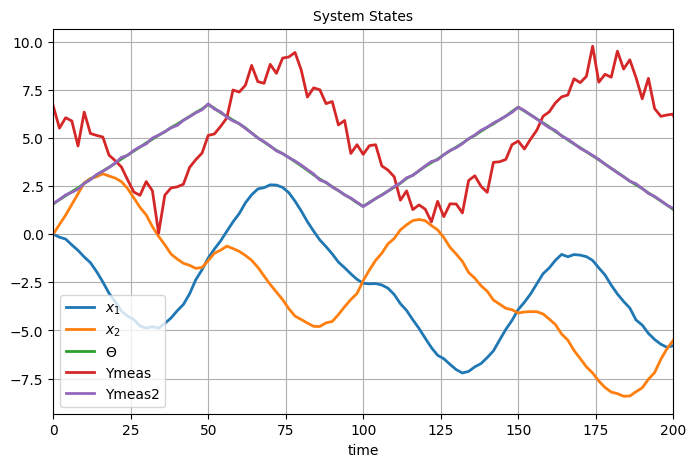

In [43]:
if 0:
    Xsm[:,:,0] = np.vstack(x0) + sqrtm(Q0)@np.vstack(randn(Nx)) # random initial pt
else:
    Xsm[:,:,0] = np.vstack(x0) 

MHE.Y = np.zeros((Ny,1,N+1+Nwind))
for k in KK[:-1]:
    MHE.Y[:,:,k] = hmeas(Xsm[:,:,k]) + sqrtm(Rd)@np.vstack(randn(Ny)) # meas with noise
    Xsm[:,:,k+1] = fdyn(Xsm[:,:,k],MHE.u[:,k],dt) + sqrtm(Wd)@np.vstack(randn(Nx))     

MHE.Y[:,:,N+Nwind] = hmeas(Xsm[:,:,N+Nwind]) + sqrtm(Rd)@np.vstack(randn(Ny)) # meas with noise
    
plt.figure(3,figsize=(8,5))
plt.plot(KK*dt,Xsm[0,0,:],label=r'$x_1$')
plt.plot(KK*dt,Xsm[1,0,:],label=r'$x_2$')
plt.plot(KK*dt,Xsm[2,0,:],label=r'$\Theta$')
plt.plot(KK*dt,MHE.Y[0,0,:],label='Ymeas')
plt.plot(KK*dt,MHE.Y[1,0,:],label='Ymeas2')
plt.xlabel('time')
plt.xlim(0,N*dt)
plt.title('System States')
plt.legend(loc='best')
plt.show()

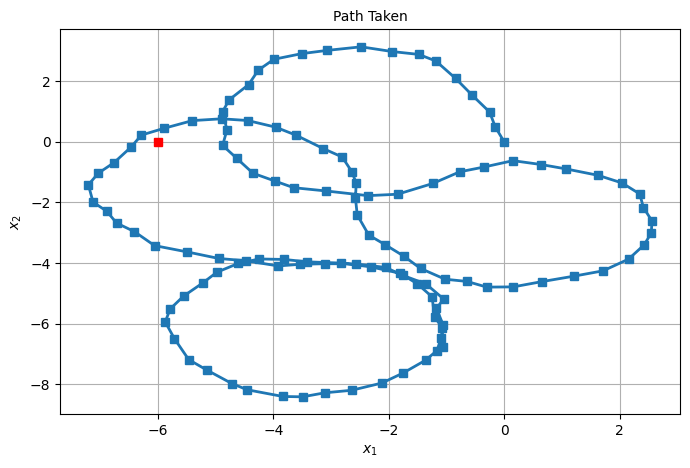

In [44]:
plt.figure(4,figsize=(8,5))
plt.plot(Xsm[0,0,:],Xsm[1,0,:],'s-')
plt.plot(X_pos[0],X_pos[1],'rs')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Path Taken')
plt.show()

## Run Estimator

In [45]:
# initialize
xm = np.copy(x0)
Qm = np.copy(Q0)
MHE.xm = copy.deepcopy(xm)
MHE.Qm = copy.deepcopy(Qm)

Xstore = Xsm*0 # get size right
Qstore = np.zeros((1,Nx,N))

for kk in np.arange(N):
    MHE.kstart = kk # used in u and y
    
    MHE = min_casadi(MHE)
    cX,cW = MHE.vars

    Xsolk = MHE.sol.value(cX)[:,0].reshape(Nx,1)
    Wsolk = MHE.sol.value(cW)[:,0].reshape(Nx,1)

    xm, Qm, Qp = Prop_one_step(Xsolk,Wsolk,MHE.Qm,kk)
    MHE.Qm = copy.deepcopy(Qm) 
    MHE.Xm = copy.deepcopy(xm) 
    
    MHE.W = copy.deepcopy(MHE.sol.value(cW))
    # store the updated pred at a given time
    Xstore[:,:,kk] = copy.deepcopy(Xsolk.reshape(Nx,1))
    Qstore[:,:,kk] = copy.deepcopy(np.diag(Qp))

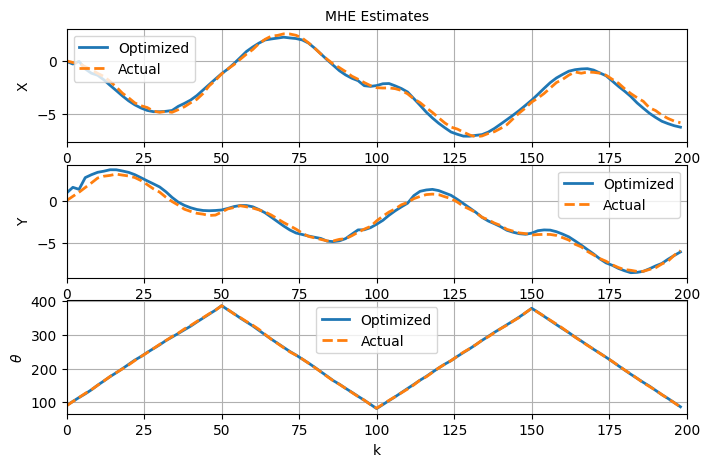

In [46]:
plt.figure(figsize=(8,5))
plt.subplot(311)
plt.plot(dt*KK[0:N],Xstore[0,0,0:N],label=r'Optimized')
plt.plot(dt*KK[0:N],Xsm[0,0,0:N],'--',label='Actual')
plt.legend(loc='best')
plt.ylabel('X')
plt.xlim([0, dt*N])
plt.grid(True)
plt.title('MHE Estimates')
plt.subplot(312)
plt.plot(dt*KK[0:N],Xstore[1,0,0:N],label=r'Optimized')
plt.plot(dt*KK[0:N],Xsm[1,0,0:N],'--',label='Actual')
plt.legend(loc='best')
plt.ylabel('Y')
plt.xlim([0, dt*N])
plt.grid(True)
#plt.tight_layout
plt.subplot(313)
plt.plot(dt*KK[0:N],Xstore[2,0,0:N]/d2r,label=r'Optimized')
plt.plot(dt*KK[0:N],Xsm[2,0,0:N]/d2r,'--',label='Actual')
plt.ylabel(r'$\theta$')
plt.legend(loc='best')
plt.xlabel('k')
plt.xlim([0, dt*N])
plt.grid(True)
plt.show()


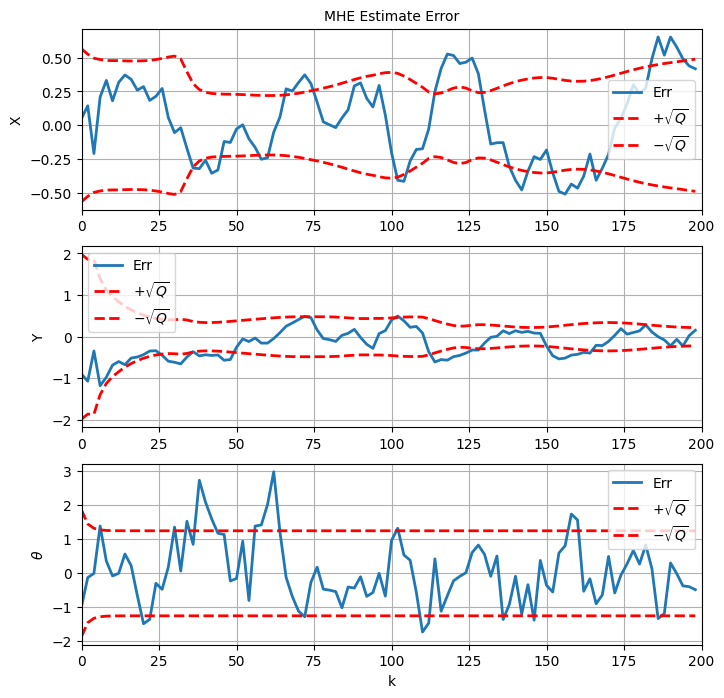

In [47]:
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(dt*KK[0:N],Xsm[0,0,0:N]-Xstore[0,0,0:N],label=r'Err')
plt.plot(dt*KK[0:N],np.sqrt(Qstore[0,0,:]),'r--',label=r'$+\sqrt{Q}$')
plt.plot(dt*KK[0:N],-np.sqrt(Qstore[0,0,:]),'r--',label=r'$-\sqrt{Q}$')
plt.legend(loc='best')
plt.ylabel('X')
plt.xlim([0, dt*N])
plt.grid(True)
plt.title('MHE Estimate Error')
plt.subplot(312)
plt.plot(dt*KK[0:N],Xsm[1,0,0:N]-Xstore[1,0,0:N],label=r'Err')
plt.plot(dt*KK[0:N],np.sqrt(Qstore[0,1,:]),'r--',label=r'$+\sqrt{Q}$')
plt.plot(dt*KK[0:N],-np.sqrt(Qstore[0,1,:]),'r--',label=r'$-\sqrt{Q}$')
plt.legend(loc='best')
plt.xlim([0, dt*N])
plt.ylabel('Y')
plt.grid(True)
#plt.tight_layout
plt.subplot(313)
plt.plot(dt*KK[0:N],Xsm[2,0,0:N]/d2r - Xstore[2,0,0:N]/d2r,label=r'Err')
plt.plot(dt*KK[0:N],np.sqrt(Qstore[0,2,:])/d2r,'r--',label=r'$+\sqrt{Q}$')
plt.plot(dt*KK[0:N],-np.sqrt(Qstore[0,2,:])/d2r,'r--',label=r'$-\sqrt{Q}$')
plt.ylabel(r'$\theta$')
plt.legend(loc='best')
plt.xlim([0, dt*N])
plt.xlabel('k')
plt.grid(True)
plt.show()